# PATHOLOGICAL GAIT RECOGNITION

In [1]:
# Setup
import os, zipfile, time, psutil
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import gc
from tensorflow.keras.callbacks import ReduceLROnPlateau

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

CONFIG = {
    'MAX_TIMESTEPS': 150,
    'NUM_FEATURES': 97,
    'NUM_FEATURES_TRIMMED': 75,  # After trimming
    'NUM_VELOCITY_FEATURES': 25,  # Top velocity features
    'LATENT_DIM': 512,  # Autoencoder latent dimension
    'TEST_SIZE': 0.2,
    'RANDOM_STATE': 42,
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'PATIENCE': 10,
    'K_FOLDS': 5
}

In [2]:
# Data Loading
drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/ColabNotebooks/humanData/HDA_proj_A2.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("✅ Data extracted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data extracted


In [3]:
# Create Manifest with Pressure Data
def create_manifest(data_dir='/content/'):
    manifest = []
    subject_dirs = sorted([d for d in os.listdir(data_dir)
                          if d.startswith('subject') and os.path.isdir(os.path.join(data_dir, d))])

    for subject_name in subject_dirs:
        subject_id = int(subject_name.replace('subject', ''))
        subject_path = os.path.join(data_dir, subject_name)

        for gait_type in sorted(os.listdir(subject_path)):
            gait_path = os.path.join(subject_path, gait_type)

            for trial_name in sorted(os.listdir(gait_path)):
                trial_id = int(trial_name.replace('trial', ''))
                trial_path = os.path.join(gait_path, trial_name)

                manifest.append({
                    'subject_id': subject_id,
                    'gait_type': gait_type,
                    'trial_id': trial_id,
                    'skeleton_path': os.path.join(trial_path, 'skeleton.csv'),
                    'pressure_path': os.path.join(trial_path, 'pressure.csv')
                })

    return pd.DataFrame(manifest)

df_manifest = create_manifest()
print(f"Found {len(df_manifest)} trials, {df_manifest['gait_type'].nunique()} gait types")

Found 1440 trials, 6 gait types


In [4]:
# Feature Engineering Functions
class FeatureEngineering:
    @staticmethod
    def calculate_joint_velocities(skeleton_sequences):
        """Calculate joint velocities from position changes"""
        velocities = []
        for seq in skeleton_sequences:
            if len(seq) < 2:
                velocities.append(np.zeros_like(seq))
                continue

            # Calculate frame-to-frame differences
            vel = np.diff(seq, axis=0)
            # Pad to maintain sequence length
            vel = np.vstack([vel[0:1], vel])
            velocities.append(vel)

        return velocities

    @staticmethod
    def trim_features(sequences, num_features):
        """Select most informative features based on variance"""
        # Flatten sequences to calculate variance
        flattened = np.vstack([seq for seq in sequences])
        variances = np.var(flattened, axis=0)
        top_indices = np.argsort(variances)[-num_features:]

        # Apply trimming
        trimmed = [seq[:, top_indices] for seq in sequences]
        return trimmed, top_indices

    @staticmethod
    def process_pressure_data(df_manifest):
        """Load and process pressure data"""
        pressure_sequences = []

        for _, row in df_manifest.iterrows():
            df_pressure = pd.read_csv(row['pressure_path'])
            df_pressure.replace([np.inf, -np.inf], 0, inplace=True)
            df_pressure.fillna(0, inplace=True)
            pressure_sequences.append(df_pressure.values)

        return pressure_sequences

In [5]:
# Enhanced Data Preprocessing
def load_and_preprocess_multimodal(df_manifest, config):
    skeleton_sequences, pressure_sequences, labels = [], [], []

    # Load all data
    for _, row in df_manifest.iterrows():
        # Skeleton data
        df_skel = pd.read_csv(row['skeleton_path'])
        df_skel.replace([np.inf, -np.inf], 0, inplace=True)
        df_skel.fillna(0, inplace=True)
        skeleton_sequences.append(df_skel.iloc[:, 1:].values)

        # Pressure data
        df_pressure = pd.read_csv(row['pressure_path'])
        df_pressure.replace([np.inf, -np.inf], 0, inplace=True)
        df_pressure.fillna(0, inplace=True)
        pressure_sequences.append(df_pressure.values)

        labels.append(row['gait_type'])

    # Calculate velocities
    fe = FeatureEngineering()
    velocity_sequences = fe.calculate_joint_velocities(skeleton_sequences)

    # Trim features
    skeleton_trimmed, skeleton_indices = fe.trim_features(
        skeleton_sequences, config['NUM_FEATURES_TRIMMED'])
    velocity_trimmed, velocity_indices = fe.trim_features(
        velocity_sequences, config['NUM_VELOCITY_FEATURES'])

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)

    # Pad sequences
    skeleton_padded = pad_sequences(skeleton_trimmed, maxlen=config['MAX_TIMESTEPS'],
                                   dtype='float32', padding='post', truncating='post')
    velocity_padded = pad_sequences(velocity_trimmed, maxlen=config['MAX_TIMESTEPS'],
                                   dtype='float32', padding='post', truncating='post')
    pressure_padded = pad_sequences(pressure_sequences, maxlen=config['MAX_TIMESTEPS'],
                                   dtype='float32', padding='post', truncating='post')

    # Split data
    X_train_sk, X_test_sk, X_train_vel, X_test_vel, X_train_pr, X_test_pr, y_train, y_test = train_test_split(
        skeleton_padded, velocity_padded, pressure_padded, labels_onehot,
        test_size=config['TEST_SIZE'], random_state=config['RANDOM_STATE'],
        stratify=labels_onehot)

    # Normalize with appropriate methods
    # Z-score for skeleton and velocity
    scaler_sk = StandardScaler()
    X_train_sk = scaler_sk.fit_transform(
        X_train_sk.reshape(-1, config['NUM_FEATURES_TRIMMED'])).reshape(X_train_sk.shape)
    X_test_sk = scaler_sk.transform(
        X_test_sk.reshape(-1, config['NUM_FEATURES_TRIMMED'])).reshape(X_test_sk.shape)

    scaler_vel = StandardScaler()
    X_train_vel = scaler_vel.fit_transform(
        X_train_vel.reshape(-1, config['NUM_VELOCITY_FEATURES'])).reshape(X_train_vel.shape)
    X_test_vel = scaler_vel.transform(
        X_test_vel.reshape(-1, config['NUM_VELOCITY_FEATURES'])).reshape(X_test_vel.shape)

    # Min-max for pressure
    scaler_pr = MinMaxScaler()
    original_shape = X_train_pr.shape
    X_train_pr = scaler_pr.fit_transform(
        X_train_pr.reshape(-1, X_train_pr.shape[-1])).reshape(original_shape)
    X_test_pr = scaler_pr.transform(
        X_test_pr.reshape(-1, X_test_pr.shape[-1])).reshape(X_test_pr.shape)

    print(f"Skeleton: {X_train_sk.shape}, Velocity: {X_train_vel.shape}, Pressure: {X_train_pr.shape}")
    print(f"Classes: {len(label_encoder.classes_)}")

    return {
        'skeleton': (X_train_sk, X_test_sk),
        'velocity': (X_train_vel, X_test_vel),
        'pressure': (X_train_pr, X_test_pr),
        'labels': (y_train, y_test),
        'label_encoder': label_encoder,
        'subject_ids': df_manifest['subject_id'].values
    }

# Load multimodal data
data_dict = load_and_preprocess_multimodal(df_manifest, CONFIG)
X_train_sk, X_test_sk = data_dict['skeleton']
X_train_vel, X_test_vel = data_dict['velocity']
X_train_pr, X_test_pr = data_dict['pressure']
y_train, y_test = data_dict['labels']
label_encoder = data_dict['label_encoder']
num_classes = y_train.shape[1]

Skeleton: (1152, 150, 75), Velocity: (1152, 150, 25), Pressure: (1152, 150, 48)
Classes: 6


In [6]:
# Fixed Autoencoder for Feature Learning
class Autoencoder:
    @staticmethod
    def build_1d_autoencoder(input_shape, latent_dim):
        """1D Convolutional Autoencoder for feature extraction"""
        # Encoder
        encoder_input = Input(shape=input_shape)
        x = Conv1D(32, 3, activation='elu', padding='same')(encoder_input)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(64, 3, activation='elu', padding='same')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(128, 3, activation='elu', padding='same')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Conv1D(256, 3, activation='elu', padding='same')(x)
        x = MaxPooling1D(2, padding='same')(x)
        x = Flatten()(x)
        latent = Dense(latent_dim)(x)

        encoder = Model(encoder_input, latent, name='encoder')

        # Calculate compressed dimensions after encoding
        # After 4 MaxPooling1D(2): 150 -> 75 -> 38 -> 19 -> 10 (approximately)
        compressed_dim = input_shape[0] // 16  # 150 // 16 = 9 (rounded)
        if compressed_dim < 1:
            compressed_dim = 1

        # Decoder - fixed dimensions
        decoder_input = Input(shape=(latent_dim,))
        x = Dense(compressed_dim * 256, activation='elu')(decoder_input)
        x = Reshape((compressed_dim, 256))(x)

        # Upsample back to original timesteps
        x = Conv1DTranspose(128, 3, strides=2, padding='same', activation='elu')(x)
        x = Conv1DTranspose(64, 3, strides=2, padding='same', activation='elu')(x)
        x = Conv1DTranspose(32, 3, strides=2, padding='same', activation='elu')(x)
        x = Conv1DTranspose(input_shape[1], 3, strides=2, padding='same')(x)

        # Adjust to exact input shape using Cropping or Padding
        # After 4 strides of 2: compressed_dim * 16
        current_timesteps = compressed_dim * 16

        if current_timesteps > input_shape[0]:
            # Need to crop
            crop_amount = current_timesteps - input_shape[0]
            decoded = Cropping1D((0, crop_amount))(x)
        elif current_timesteps < input_shape[0]:
            # Need to pad
            pad_amount = input_shape[0] - current_timesteps
            decoded = ZeroPadding1D((0, pad_amount))(x)
        else:
            decoded = x

        decoder = Model(decoder_input, decoded, name='decoder')

        # Full autoencoder
        autoencoder_input = Input(shape=input_shape)
        encoded = encoder(autoencoder_input)
        decoded = decoder(encoded)
        autoencoder = Model(autoencoder_input, decoded, name='autoencoder')

        return autoencoder, encoder, decoder

    @staticmethod
    def train_autoencoder(X_train, X_val, config):
        """Train autoencoder and return encoder"""
        input_shape = X_train.shape[1:]
        autoencoder, encoder, decoder = Autoencoder.build_1d_autoencoder(
            input_shape, config['LATENT_DIM'])

        autoencoder.compile(optimizer='adam', loss='mse')

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        print("Training autoencoder for feature extraction...")
        history = autoencoder.fit(X_train, X_train,
                                 epochs=50, batch_size=64,
                                 validation_data=(X_val, X_val),
                                 callbacks=[early_stop], verbose=1)

        print(f"Autoencoder MSE: {autoencoder.evaluate(X_val, X_val, verbose=0):.4f}")

        return encoder

# Train autoencoder on skeleton data
encoder = Autoencoder.train_autoencoder(X_train_sk, X_test_sk, CONFIG)

# Extract encoded features
X_train_encoded = encoder.predict(X_train_sk)
X_test_encoded = encoder.predict(X_test_sk)
X_train_encoded = X_train_encoded.reshape(-1, 1, CONFIG['LATENT_DIM'])
X_test_encoded = X_test_encoded.reshape(-1, 1, CONFIG['LATENT_DIM'])
print(f"Encoded features shape: {X_train_encoded.shape}")

Training autoencoder for feature extraction...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.8714 - val_loss: 0.6350
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5602 - val_loss: 0.4080
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4079 - val_loss: 0.3172
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3113 - val_loss: 0.2637
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2562 - val_loss: 0.2351
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2531 - val_loss: 0.2168
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2115 - val_loss: 0.2045
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2074 - val_loss: 0.1918
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1818 - val_loss: 0.1833
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1725 - val_loss: 0.1718
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1755 - val_loss: 0.1653
Epoch 12/50
18/

In [7]:
# Enhanced Model Definitions with Multimodal Support
class Models:
    @staticmethod
    def baseline(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            LSTM(128),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def dual_lstm(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            LSTM(128, return_sequences=True),
            Dropout(0.3),
            LSTM(64),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def light(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            LSTM(64),
            Dropout(0.4),
            Dense(32, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def deep_dense(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            LSTM(128),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def bilstm(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            Bidirectional(LSTM(64, return_sequences=True)),
            Dropout(0.4),
            Bidirectional(LSTM(32)),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def cnn_lstm(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            Conv1D(64, 3, activation='relu', padding='same'),
            Conv1D(128, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Dropout(0.3),
            LSTM(100, return_sequences=True),
            LSTM(50),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def gru(input_shape, num_classes):
        return Sequential([
            Input(shape=input_shape),
            Masking(mask_value=0.),
            GRU(128, return_sequences=True),
            Dropout(0.3),
            GRU(64),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

    @staticmethod
    def attention(input_shape, num_classes):
        inputs = Input(shape=input_shape)
        x = Masking(mask_value=0.)(inputs)
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        return Model(inputs, outputs)

    # Multimodal model
    @staticmethod
    def gru_cnn_fusion(input_shape_skeleton, input_shape_pressure, num_classes):
        """GRU for skeleton + CNN for pressure"""
        # Skeleton branch (GRU)
        skeleton_input = Input(shape=input_shape_skeleton)
        x_sk = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(skeleton_input)
        x_sk = BatchNormalization()(x_sk)
        x_sk = GRU(192, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3))(x_sk)
        x_sk = BatchNormalization()(x_sk)
        x_sk = Dropout(0.4)(x_sk)
        x_sk = GRU(64, kernel_regularizer=regularizers.l2(1e-3))(x_sk)

        # Pressure branch (CNN)
        pressure_input = Input(shape=input_shape_pressure)
        x_pr = Conv1D(64, 3, activation='relu', padding='same')(pressure_input)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = Conv1D(128, 3, activation='relu', padding='same')(x_pr)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = GlobalAveragePooling1D()(x_pr)

        # Fusion
        x = Concatenate()([x_sk, x_pr])
        x = Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        return Model([skeleton_input, pressure_input], outputs)

    # Multimodal model
    @staticmethod
    def gru_cnn_fusion_encoded(input_shape_encoded, input_shape_pressure, num_classes):
        """
        Multimodal model:
        - GRU branch for AUTOENCODED skeleton features.
        - CNN branch for raw pressure features.
        """
        # Encoded Skeleton Branch (GRU)
        # This branch is designed for the (1, 512) shape of the autoencoder's output
        encoded_input = Input(shape=input_shape_encoded, name='encoded_skeleton_input')
        x_sk = GRU(192, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3))(encoded_input)
        x_sk = BatchNormalization()(x_sk)
        x_sk = Dropout(0.4)(x_sk)
        x_sk = GRU(64, kernel_regularizer=regularizers.l2(1e-3), name='gru_skeleton_output')(x_sk)

        # Pressure Branch (CNN)
        # Same as previous multimodal model
        pressure_input = Input(shape=input_shape_pressure, name='pressure_input')
        x_pr = Conv1D(64, 3, activation='relu', padding='same')(pressure_input)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = Conv1D(128, 3, activation='relu', padding='same')(x_pr)
        x_pr = MaxPooling1D(2)(x_pr)
        x_pr = GlobalAveragePooling1D(name='cnn_pressure_output')(x_pr)

        # Fusion
        # Combine the outputs of both branches
        x = Concatenate()([x_sk, x_pr])
        x = Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        # Create the final model with two inputs
        model = Model(inputs=[encoded_input, pressure_input], outputs=outputs)
        return model

    @staticmethod
    def encoded_gru(input_shape, num_classes):
        """GRU on autoencoded features"""
        return Sequential([
            Input(shape=input_shape),
            Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
            BatchNormalization(),
            GRU(192, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3)),
            BatchNormalization(),
            Dropout(0.4),
            GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-3)),
            BatchNormalization(),
            Dropout(0.4),
            GRU(64, kernel_regularizer=regularizers.l2(1e-3)),
            BatchNormalization(),
            Dropout(0.4),
            Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

In [8]:
# Enhanced Training Pipeline with Performance Monitoring
def train_model_enhanced(model_func, model_name, X_train, y_train, X_test, y_test, config,
                         multimodal=False, X_train_pr=None, X_test_pr=None):
    print(f"\n{'='*50}\nTraining: {model_name}")

    # Performance monitoring
    start_time = time.time()
    process = psutil.Process()

    # Build and compile
    if multimodal:
        model = model_func(X_train[0].shape[1:], X_train_pr.shape[1:], y_train.shape[1])
        train_data = [X_train[0], X_train_pr]
        test_data = [X_test[0], X_test_pr]
    else:
        if isinstance(X_train, tuple):
            X_train = X_train[0]
            X_test = X_test[0]

        model = model_func(X_train.shape[1:], y_train.shape[1])
        train_data = X_train
        test_data = X_test

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Create tf.data dataset for optimization
    dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train))
    dataset = dataset.shuffle(buffer_size=1000)

    val_split = int(0.8 * len(y_train))
    train_dataset = dataset.take(val_split).batch(config['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)
    val_dataset = dataset.skip(val_split).batch(config['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = model.fit(train_dataset, epochs=config['EPOCHS'],
                       validation_data=val_dataset, callbacks=[early_stop], verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(test_data, y_test, verbose=0)

    # Performance metrics
    training_time = time.time() - start_time
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    cpu_percent = psutil.cpu_percent(interval=1)
    num_params = model.count_params()

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"CPU Usage: {cpu_percent:.1f}%")
    print(f"Parameters: {num_params:,}")

    return {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'epochs': len(history.history['loss']),
        'training_time': training_time,
        'memory_usage': memory_usage,
        'num_params': num_params
    }

In [9]:
# Enhanced Training Pipeline with Performance Monitoring
def train_model_enhanced(model_func, model_name, X_train, y_train, X_test, y_test, config,
                         multimodal=False, X_train_pr=None, X_test_pr=None):
    print(f"\n{'='*50}\nTraining: {model_name}")

    # Performance monitoring
    start_time = time.time()
    process = psutil.Process()

    # Build and compile
    if multimodal:
        model = model_func(X_train[0].shape[1:], X_train_pr.shape[1:], y_train.shape[1])
        # Tuple for multiple inputs
        train_data = (X_train[0], X_train_pr)
        test_data = (X_test[0], X_test_pr)
    else:
        if isinstance(X_train, tuple):
            X_train = X_train[0]
            X_test = X_test[0]

        model = model_func(X_train.shape[1:], y_train.shape[1])
        train_data = X_train
        test_data = X_test

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Create tf.data dataset for optimization
    # Receives a tuple for multimodal data
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(config['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((train_data, y_train))
    val_dataset = val_dataset.take(len(y_train)).skip(int(0.8 * len(y_train))).batch(config['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)
    train_dataset = train_dataset.take(int(0.8 * len(y_train)))


    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=config['PATIENCE'], restore_best_weights=True)
    history = model.fit(train_dataset, epochs=config['EPOCHS'],
                       validation_data=val_dataset, callbacks=[early_stop], verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(test_data, y_test, verbose=0)

    # Performance metrics
    training_time = time.time() - start_time
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    cpu_percent = psutil.cpu_percent(interval=1)
    num_params = model.count_params()

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"CPU Usage: {cpu_percent:.1f}%")
    print(f"Parameters: {num_params:,}")

    return {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'epochs': len(history.history['loss']),
        'training_time': training_time,
        'memory_usage': memory_usage,
        'num_params': num_params
    }

In [10]:
# Train All Models
models_to_test = {
    'baseline': (Models.baseline, X_train_sk, X_test_sk),
    'dual_lstm': (Models.dual_lstm, X_train_sk, X_test_sk),
    'light': (Models.light, X_train_sk, X_test_sk),
    'deep_dense': (Models.deep_dense, X_train_sk, X_test_sk),
    'bilstm': (Models.bilstm, X_train_sk, X_test_sk),
    'cnn_lstm': (Models.cnn_lstm, X_train_sk, X_test_sk),
    'gru': (Models.gru, X_train_sk, X_test_sk),
    'attention': (Models.attention, X_train_sk, X_test_sk),
    'encoded_gru': (Models.encoded_gru, X_train_encoded, X_test_encoded),
}

results = {}
for name, (func, X_tr, X_te) in models_to_test.items():
    results[name] = train_model_enhanced(func, name, X_tr, y_train, X_te, y_test, CONFIG)

# Train multimodal models separately
results['gru_cnn_fusion'] = train_model_enhanced(
    Models.gru_cnn_fusion, 'gru_cnn_fusion',
    (X_train_sk, X_train_sk), y_train, (X_test_sk, X_test_sk), y_test, CONFIG,
    multimodal=True, X_train_pr=X_train_pr, X_test_pr=X_test_pr)

results['gru_cnn_fusion_encoded'] = train_model_enhanced(
    Models.gru_cnn_fusion_encoded,
    'gru_cnn_fusion_encoded',
    (X_train_encoded, X_train_encoded),
    y_train,
    (X_test_encoded, X_test_encoded),
    y_test,
    CONFIG,
    multimodal=True,
    X_train_pr=X_train_pr,
    X_test_pr=X_test_pr)


Training: baseline
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1784 - loss: 1.8855 - val_accuracy: 0.3333 - val_loss: 1.6816
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2470 - loss: 1.7569 - val_accuracy: 0.3983 - val_loss: 1.5757
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3319 - loss: 1.6242 - val_accuracy: 0.4459 - val_loss: 1.3496
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3538 - loss: 1.5136 - val_accuracy: 0.5801 - val_loss: 1.1513
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4814 - loss: 1.2972 - val_accuracy: 0.6407 - val_loss: 0.9999
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4992 - loss: 1.1953 - val_accuracy: 0.5714 - val_loss: 1.1463
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5040 - loss: 1.3044 - val_accuracy: 0.7186 - val_loss: 0.8592
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5659 - loss: 1.145

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.2116 - loss: 1.7742 - val_accuracy: 0.3939 - val_loss: 1.4079
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3694 - loss: 1.5004 - val_accuracy: 0.4848 - val_loss: 1.3384
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4058 - loss: 1.4181 - val_accuracy: 0.5108 - val_loss: 1.1424
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4752 - loss: 1.2369 - val_accuracy: 0.6277 - val_loss: 0.9904
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5475 - loss: 1.1213 - val_accuracy: 0.6450 - val_loss: 0.9534
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5962 - loss: 1.0105 - val_accuracy: 0.6840 - val_loss: 0.7589
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6607 - loss: 0.8443 - val_accuracy: 0.7619 - val_loss: 0.6032
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6990 - loss: 0.7810 - val_accuracy: 0.

In [11]:
best_model_name = max(results, key=lambda name: results[name]['test_accuracy'])
print(f"🏆 Best model selected for K-Fold and LOSO: {best_model_name}")

🏆 Best model selected for K-Fold and LOSO: gru_cnn_fusion


In [12]:
# K-Fold Cross Validation
def kfold_validation(model_func, X, y, config, model_name="Model"):
    print(f"\n{'='*50}\nK-Fold Validation: {model_name}")

    kfold = KFold(n_splits=config['K_FOLDS'], shuffle=True, random_state=config['RANDOM_STATE'])
    accuracies = []

    # Check if the model is multimodal by seeing if X is a tuple of datasets
    is_multimodal = isinstance(X, tuple)

    # Use the first dataset for splitting indices
    data_for_splitting = X[0] if is_multimodal else X

    for fold, (train_idx, val_idx) in enumerate(kfold.split(data_for_splitting), 1):
        print(f"Fold {fold}/{config['K_FOLDS']}")

        if is_multimodal:
            # Handle multimodal data splitting
            X_train_fold = (X[0][train_idx], X[1][train_idx])
            X_val_fold = (X[0][val_idx], X[1][val_idx])
            # Build the multimodal model with the correct number of inputs
            model = model_func(X[0].shape[1:], X[1].shape[1:], y.shape[1])
        else:
            # Handle unimodal data splitting
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            # Build the unimodal model
            model = model_func(X.shape[1:], y.shape[1])

        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)

        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32,
                  validation_data=(X_val_fold, y_val_fold),
                  callbacks=[early_stop, reduce_lr], verbose=0)

        _, acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracies.append(acc)
        print(f"  Fold {fold} Accuracy: {acc:.4f}")

        # Clear memory after each fold
        tf.keras.backend.clear_session()
        gc.collect()


    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return mean_acc, std_acc, accuracies

# Run K-fold for the best model
best_models_to_validate = [best_model_name]
kfold_results = {}

# Combine train and test for the full dataset
X_full_sk = np.vstack([X_train_sk, X_test_sk])
X_full_encoded = np.vstack([X_train_encoded, X_test_encoded])
X_full_pr = np.vstack([X_train_pr, X_test_pr])
y_full = np.vstack([y_train, y_test])

for model_name in best_models_to_validate:
    model_func = getattr(Models, model_name)

    if model_name == 'encoded_gru':
        X_data = X_full_encoded
    elif model_name == 'gru_cnn_fusion':
        # Pass data as a tuple for multimodal models
        X_data = (X_full_sk, X_full_pr)
    else:
        X_data = X_full_sk

    mean_acc, std_acc, fold_accs = kfold_validation(
        model_func, X_data, y_full, CONFIG, model_name)
    kfold_results[model_name] = {
        'mean': mean_acc, 'std': std_acc, 'folds': fold_accs
    }


K-Fold Validation: gru_cnn_fusion
Fold 1/5
  Fold 1 Accuracy: 0.9479
Fold 2/5
  Fold 2 Accuracy: 0.9479
Fold 3/5
  Fold 3 Accuracy: 0.9132
Fold 4/5
  Fold 4 Accuracy: 0.9410
Fold 5/5
  Fold 5 Accuracy: 0.9653
Mean Accuracy: 0.9431 ± 0.0170


In [13]:
# Leave-One-Subject-Out (LOSO) Validation
def loso_validation(model_func, X, y, subject_ids, config, model_name="Model"):
    print(f"\n{'='*50}\nLOSO Validation: {model_name}")

    unique_subjects = np.unique(subject_ids)
    accuracies = []

    is_multimodal = isinstance(X, tuple)

    for test_subject in unique_subjects:
        train_mask = subject_ids != test_subject
        test_mask = subject_ids == test_subject

        if is_multimodal:
            X_train_loso = (X[0][train_mask], X[1][train_mask])
            X_test_loso = (X[0][test_mask], X[1][test_mask])
            model = model_func(X[0].shape[1:], X[1].shape[1:], y.shape[1])
        else:
            X_train_loso = X[train_mask]
            X_test_loso = X[test_mask]
            model = model_func(X.shape[1:], y.shape[1])

        y_train_loso = y[train_mask]
        y_test_loso = y[test_mask]

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)

        model.fit(X_train_loso, y_train_loso, epochs=50, batch_size=32,
                  validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=0)

        _, acc = model.evaluate(X_test_loso, y_test_loso, verbose=0)
        accuracies.append(acc)
        print(f"  Subject {test_subject}: {acc:.4f}")

        # Clear memory
        tf.keras.backend.clear_session()
        gc.collect()

    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"LOSO Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return mean_acc, std_acc, accuracies

# Run LOSO for the best model
loso_results = {}
for model_name in [best_model_name]:

    model_func = getattr(Models, model_name)

    if model_name == 'encoded_gru':
        X_data = X_full_encoded
    elif model_name == 'gru_cnn_fusion':
         # Pass data as a tuple for multimodal models
        X_data = (X_full_sk, X_full_pr)
    else:
        X_data = X_full_sk

    mean_acc, std_acc, subj_accs = loso_validation(
        model_func, X_data, y_full,
        data_dict['subject_ids'], CONFIG, model_name)
    loso_results[model_name] = {
        'mean': mean_acc, 'std': std_acc, 'subjects': subj_accs
    }


LOSO Validation: gru_cnn_fusion
  Subject 1: 0.9500
  Subject 2: 0.9500
  Subject 3: 0.9583
  Subject 4: 0.9000
  Subject 5: 0.9333
  Subject 6: 0.9500
  Subject 7: 0.8917
  Subject 8: 0.9667
  Subject 9: 0.9500
  Subject 10: 0.9083
  Subject 11: 0.9750
  Subject 12: 0.9417
LOSO Mean Accuracy: 0.9396 ± 0.0253


In [14]:
# Enhanced Results Comparison
df_results = pd.DataFrame([{
    'Model': name,
    'Accuracy': r['test_accuracy'],
    'Loss': r['test_loss'],
    'Epochs': r['epochs'],
    'Time (s)': r['training_time'],
    'Memory (MB)': r['memory_usage'],
    'Parameters': r['num_params']
} for name, r in results.items()]).sort_values('Accuracy', ascending=False)

print("\n" + "="*70)
print("ENHANCED RESULTS COMPARISON")
print("="*70)
print(df_results.to_string(index=False))

# Add validation results
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS")
print("="*70)
for model, res in kfold_results.items():
    print(f"{model}: {res['mean']:.4f} ± {res['std']:.4f}")

print("\n" + "="*70)
print("LOSO VALIDATION RESULTS")
print("="*70)
for model, res in loso_results.items():
    print(f"{model}: {res['mean']:.4f} ± {res['std']:.4f}")


ENHANCED RESULTS COMPARISON
                 Model  Accuracy     Loss  Epochs   Time (s)  Memory (MB)  Parameters
        gru_cnn_fusion  0.937500 0.455243      63  80.037483  3574.257812      551014
              cnn_lstm  0.899306 0.430547      65  57.684686  2705.445312      164622
             attention  0.899306 0.474170      52  46.918446  3330.121094      179142
                   gru  0.892361 0.675518     100  98.093125  3245.531250      120518
             dual_lstm  0.888889 0.377536      46  50.249768  2482.699219      158406
            deep_dense  0.878472 0.435501      65  49.065293  3019.835938      131494
              baseline  0.875000 0.388913      67  45.850880  2620.085938      113094
                bilstm  0.861111 0.516563      66 106.971291  3091.503906      117446
gru_cnn_fusion_encoded  0.843750 0.841329     100  63.441418  2931.328125      510054
                 light  0.840278 0.498940      50  30.407718  3030.160156       38118
           encoded_gru  0


🏆 Best Model: gru_cnn_fusion
Accuracy: 0.9375
Training Time: 80.04s
Parameters: 551,014

Detailed Classification Report:
               precision    recall  f1-score   support
antalgic        0.936170  0.916667  0.926316   48.0000
lurching        0.957447  0.937500  0.947368   48.0000
normal          0.978261  0.937500  0.957447   48.0000
steppage        0.940000  0.979167  0.959184   48.0000
stiff-legged    1.000000  0.916667  0.956522   48.0000
trendelenburg   0.833333  0.937500  0.882353   48.0000
accuracy        0.937500  0.937500  0.937500    0.9375
macro avg       0.940869  0.937500  0.938198  288.0000
weighted avg    0.940869  0.937500  0.938198  288.0000


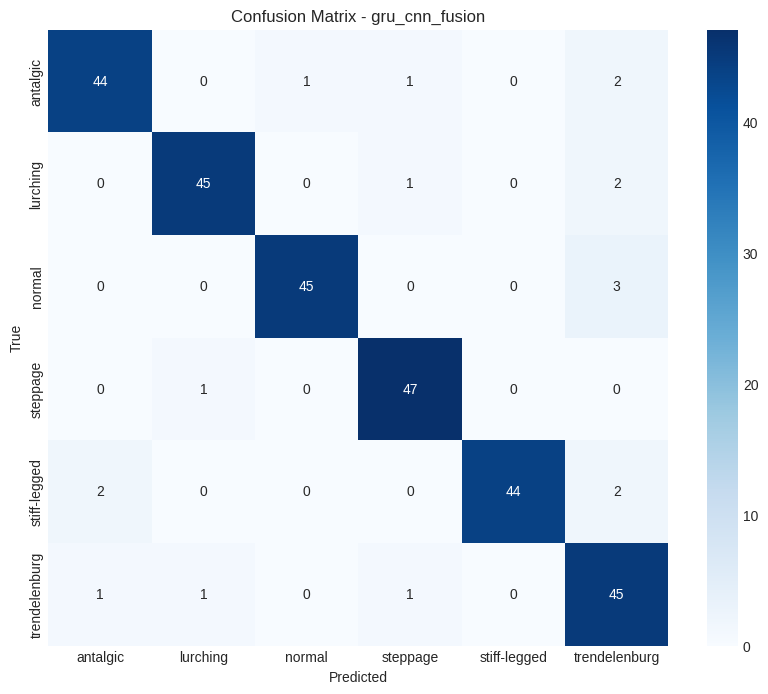


✅ Enhanced analysis complete!


In [15]:
# Best Model Analysis with Enhanced Metrics
best_model_name = df_results.iloc[0]['Model']
best_results = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Accuracy: {df_results.iloc[0]['Accuracy']:.4f}")
print(f"Training Time: {df_results.iloc[0]['Time (s)']:.2f}s")
print(f"Parameters: {df_results.iloc[0]['Parameters']:,}")

# Predictions
if best_model_name == 'gru_cnn_fusion':
    y_pred = np.argmax(best_results['model'].predict([X_test_sk, X_test_pr], verbose=0), axis=1)
elif best_model_name == 'encoded_gru':
    y_pred = np.argmax(best_results['model'].predict(X_test_encoded, verbose=0), axis=1)
else:
    y_pred = np.argmax(best_results['model'].predict(X_test_sk, verbose=0), axis=1)

y_true = np.argmax(y_test, axis=1)

# Enhanced classification report
print("\nDetailed Classification Report:")
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

# Save results
df_report.to_csv(f'{best_model_name}_results.csv')

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

print("\n✅ Enhanced analysis complete!")

# Walkthrough

In [16]:
# Save best model for demo
best_model = results[best_model_name]['model']
best_model.save(f'{best_model_name}_demo.h5')
print(f"Saved {best_model_name} for demo")

# Demo Configuration
DEMO_CONFIG = {
    'model_path': f'{best_model_name}_demo.h5',
    'num_examples': 5,
    'animation_frames': 50
}

Saved gru_cnn_fusion for demo


In [17]:
# Demo Functions
class GaitDemo:
    def __init__(self, model, label_encoder, scaler=None):
        self.model = model
        self.label_encoder = label_encoder
        self.scaler = scaler

    def predict_single(self, skeleton_sequence, pressure_sequence, return_probs=True):
        """Predict gait type for a single multimodal sequence"""
        # Preprocess inputs
        sk_seq = skeleton_sequence.reshape(1, *skeleton_sequence.shape)
        pr_seq = pressure_sequence.reshape(1, *pressure_sequence.shape)

        # Predict using both inputs
        predictions = self.model.predict([sk_seq, pr_seq], verbose=0)
        predicted_class = np.argmax(predictions[0])
        predicted_label = self.label_encoder.inverse_transform([predicted_class])[0]

        if return_probs:
            return predicted_label, predictions[0]
        return predicted_label

    def visualize_prediction(self, skeleton_sequence, pressure_sequence, true_label=None):
        """Visualize skeleton, pressure, and prediction"""
        # Get prediction using both inputs
        predicted_label, probs = self.predict_single(skeleton_sequence, pressure_sequence)

        # Create visualization
        fig = plt.figure(figsize=(15, 5))

        # 1. Skeleton trajectory
        ax1 = fig.add_subplot(131)
        joint_data = skeleton_sequence.reshape(-1, CONFIG['NUM_FEATURES_TRIMMED'])
        ax1.imshow(joint_data.T, aspect='auto', cmap='viridis')
        ax1.set_title('Skeleton Features Over Time')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Features')

        # 2. Confidence scores
        ax2 = fig.add_subplot(132)
        classes = self.label_encoder.classes_
        colors = ['green' if c == predicted_label else 'gray' for c in classes]
        bars = ax2.bar(classes, probs, color=colors)
        ax2.set_title('Prediction Confidence')
        ax2.set_ylabel('Probability')
        ax2.set_ylim([0, 1])
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{prob:.2f}', ha='center', va='bottom')

        # 3. Pressure data heatmap
        ax3 = fig.add_subplot(133)
        sns.heatmap(pressure_sequence.T, cmap='plasma', ax=ax3)
        ax3.set_title('Pressure Features Over Time')
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('Sensors')


        # Add title with results
        if true_label:
            status = "✓ Correct" if true_label == predicted_label else "✗ Incorrect"
            fig.suptitle(f'Predicted: {predicted_label} | True: {true_label} | {status}',
                        fontsize=14, fontweight='bold')
        else:
            fig.suptitle(f'Predicted: {predicted_label}', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        return predicted_label, probs

    def batch_demo(self, X_sk_samples, X_pr_samples, y_true_samples, sample_indices=None):
        """Run demo on multiple samples"""
        if sample_indices is None:
            sample_indices = np.random.choice(len(X_sk_samples),
                                            min(DEMO_CONFIG['num_examples'], len(X_sk_samples)),
                                            replace=False)

        results = []
        for idx in sample_indices:
            print(f"\\n{'='*50}")
            print(f"EXAMPLE {len(results)+1}")
            print('='*50)

            true_label = self.label_encoder.inverse_transform([np.argmax(y_true_samples[idx])])[0]
            # Pass both skeleton and pressure data to the visualization function
            pred_label, probs = self.visualize_prediction(X_sk_samples[idx], X_pr_samples[idx], true_label)

            results.append({
                'true': true_label,
                'predicted': pred_label,
                'confidence': np.max(probs),
                'correct': true_label == pred_label
            })
            time.sleep(0.5)

        return pd.DataFrame(results)

# Initialize demo
demo = GaitDemo(best_model, label_encoder, None)

LIVE GAIT CLASSIFICATION DEMO
\n==================================================
EXAMPLE 1


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


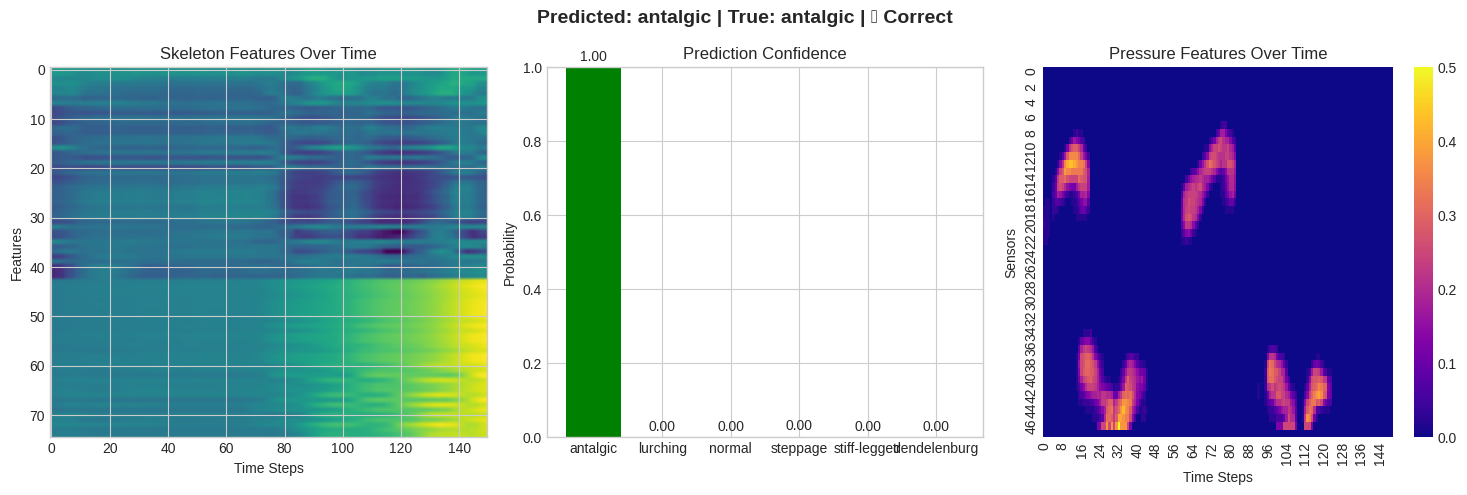

\n==================================================
EXAMPLE 2


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


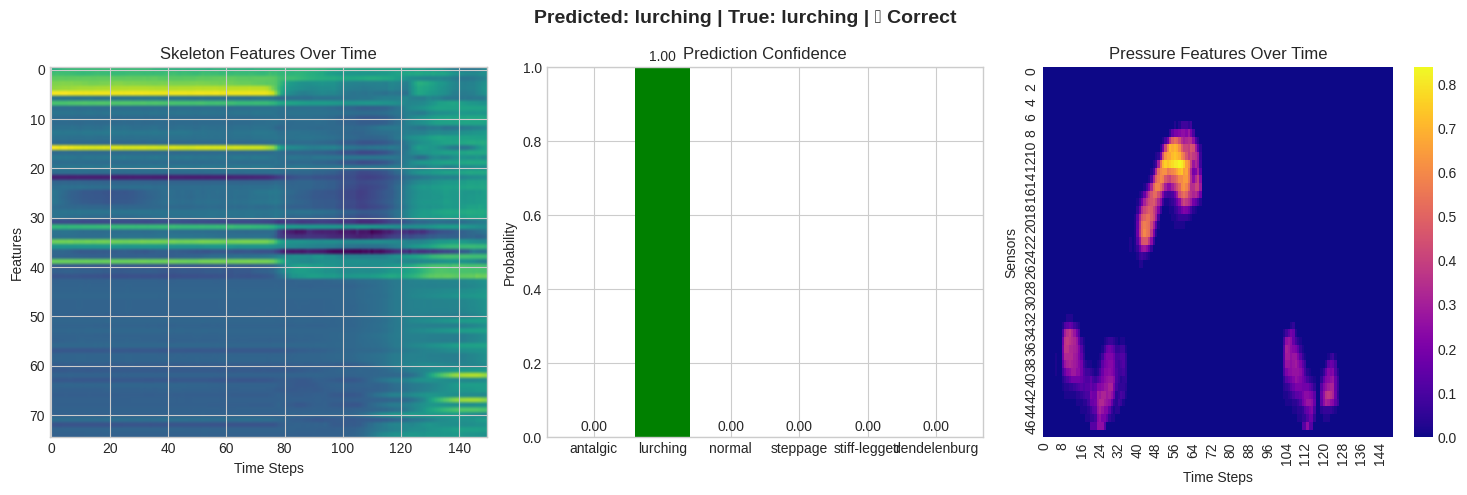

\n==================================================
EXAMPLE 3


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


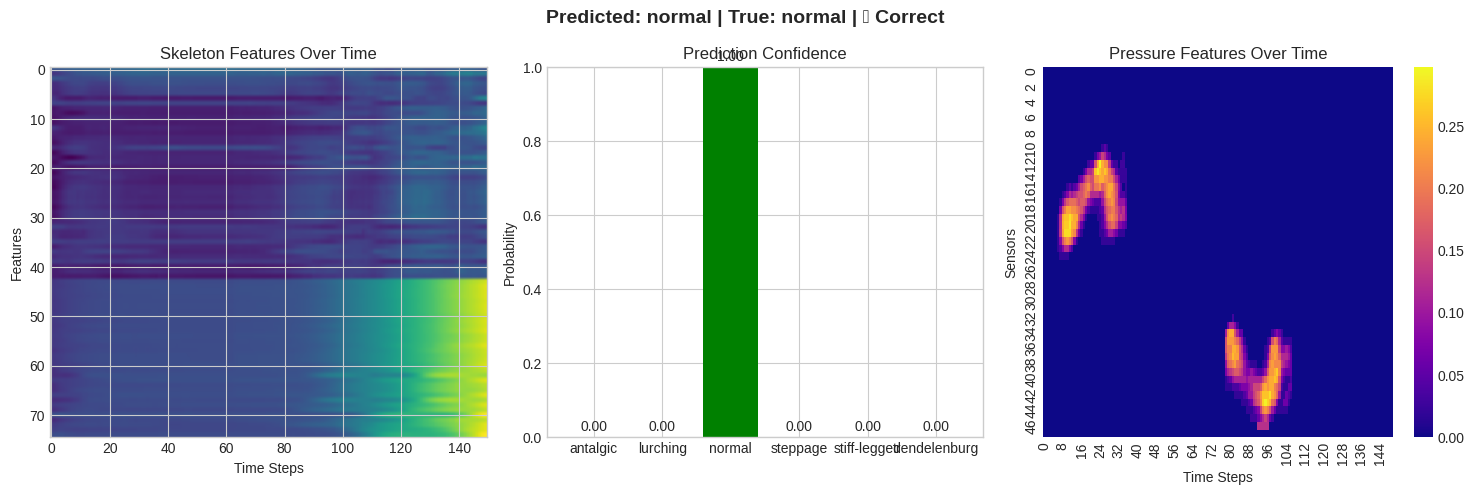

\n==================================================
EXAMPLE 4


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


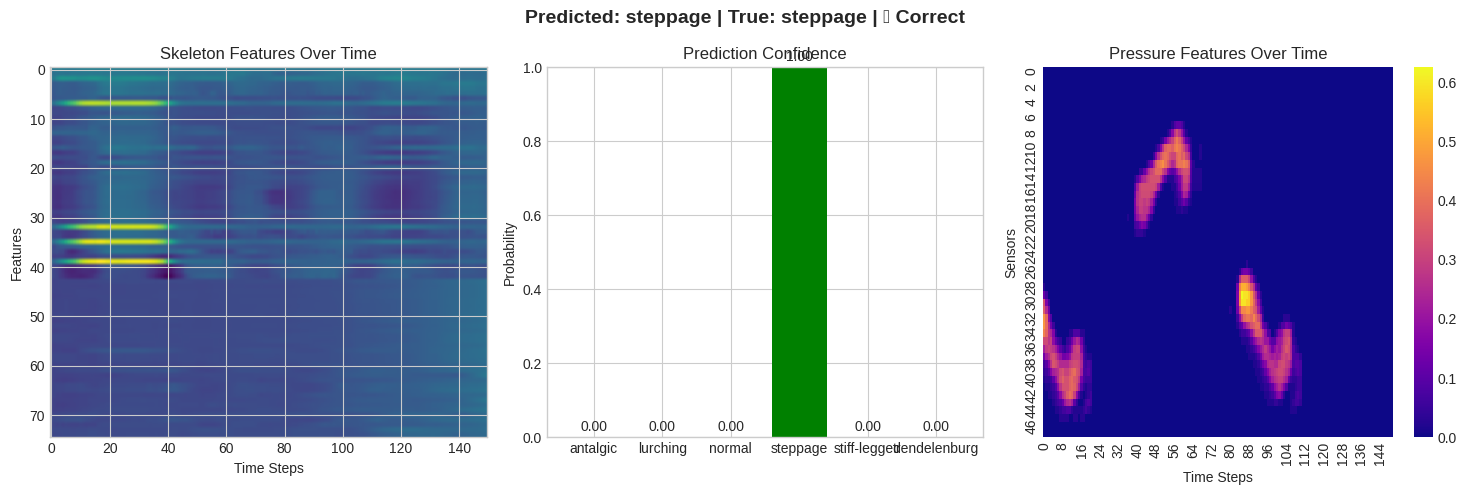

\n==================================================
EXAMPLE 5


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


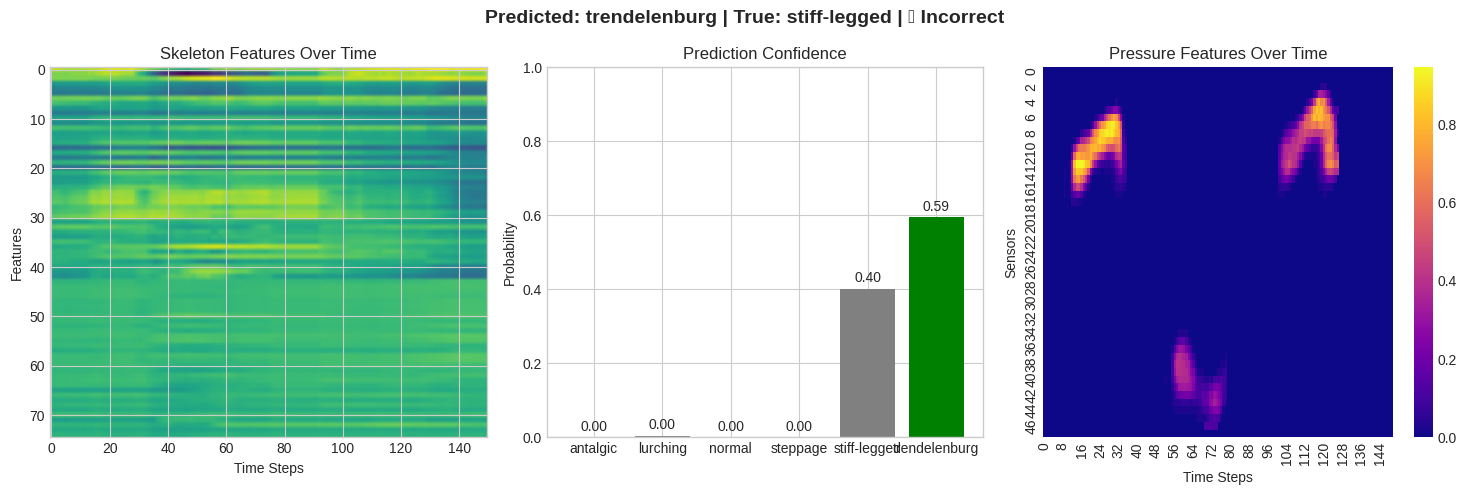

\n==================================================
EXAMPLE 6


/tmp/ipython-input-2891487040.py:67: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


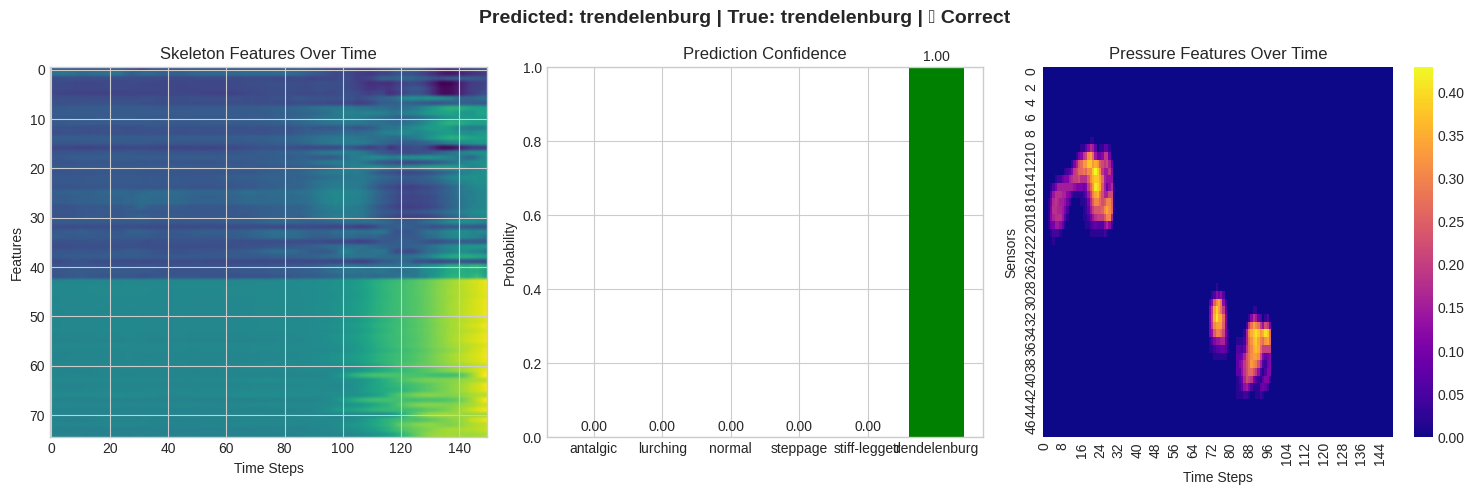

\n======================================================================
DEMO SUMMARY
            true      predicted  confidence  correct
0       antalgic       antalgic    0.999480     True
1       lurching       lurching    0.999998     True
2         normal         normal    0.999995     True
3       steppage       steppage    0.999957     True
4   stiff-legged  trendelenburg    0.594495    False
5  trendelenburg  trendelenburg    0.999796     True
\nAccuracy on demo samples: 83.33%
Average confidence: 93.23%


In [18]:
# Run Interactive Demo
print("="*70)
print("LIVE GAIT CLASSIFICATION DEMO")
print("="*70)

# Select diverse examples (one from each class if possible)
demo_indices = []
for gait_type in label_encoder.classes_:
    gait_idx = np.where(np.argmax(y_test, axis=1) ==
                       label_encoder.transform([gait_type])[0])[0]
    if len(gait_idx) > 0:
        demo_indices.append(gait_idx[0])

# Run demo with correct data based on the best model
if best_model_name == 'encoded_gru':
    # This case requires a different demo setup if inputs differ
    print(f"Demo for {best_model_name} requires encoded data.")
    # demo_results = demo.batch_demo(...)
elif best_model_name == 'gru_cnn_fusion':
    demo_results = demo.batch_demo(X_test_sk, X_test_pr, y_test, demo_indices)
else: # For all other single-input models
    # This part assumes a single input demo function, which we removed.
    # To run demos on other models, you'd adapt the demo class.
    print(f"Demo for single-input model '{best_model_name}' needs adaptation.")


# Summary statistics
if 'demo_results' in locals():
    print("\\n" + "="*70)
    print("DEMO SUMMARY")
    print("="*70)
    print(demo_results)
    print(f"\\nAccuracy on demo samples: {demo_results['correct'].mean():.2%}")
    print(f"Average confidence: {demo_results['confidence'].mean():.2%}")

In [19]:
# Real-time Simulation
class RealTimeGaitSimulator:
    def __init__(self, model, sk_sequences, pr_sequences, labels, encoder):
        self.model = model
        self.sk_sequences = sk_sequences
        self.pr_sequences = pr_sequences # Pressure data
        self.labels = labels
        self.encoder = encoder

    def simulate_stream(self, sequence_idx, window_size=30):
        """Simulate real-time classification with sliding window"""
        full_sk_sequence = self.sk_sequences[sequence_idx]
        full_pr_sequence = self.pr_sequences[sequence_idx] # Pressure data
        true_label = self.encoder.inverse_transform([np.argmax(self.labels[sequence_idx])])[0]

        print(f"\\nSimulating real-time classification for: {true_label}")
        print("-" * 50)

        predictions_over_time = []
        confidences_over_time = []

        for t in range(window_size, len(full_sk_sequence), 5):
            window_sk = full_sk_sequence[t-window_size:t]
            window_pr = full_pr_sequence[t-window_size:t] # Get window for pressure data

            # Pad skeleton window
            window_padded_sk = np.zeros((CONFIG['MAX_TIMESTEPS'], window_sk.shape[1]))
            window_padded_sk[:len(window_sk)] = window_sk

            # Pad pressure window
            window_padded_pr = np.zeros((CONFIG['MAX_TIMESTEPS'], window_pr.shape[1]))
            window_padded_pr[:len(window_pr)] = window_pr

            # Predict with both inputs
            input_sk = window_padded_sk.reshape(1, *window_padded_sk.shape)
            input_pr = window_padded_pr.reshape(1, *window_padded_pr.shape)
            pred_probs = self.model.predict([input_sk, input_pr], verbose=0)[0]

            pred_class = np.argmax(pred_probs)
            pred_label = self.encoder.inverse_transform([pred_class])[0]
            confidence = np.max(pred_probs)

            predictions_over_time.append(pred_label)
            confidences_over_time.append(confidence)

            print(f"Time {t:3d}: Predicted={pred_label:10s} Confidence={confidence:.2f}")

        from collections import Counter
        final_prediction = Counter(predictions_over_time).most_common(1)[0][0]
        avg_confidence = np.mean(confidences_over_time)

        print("-" * 50)
        print(f"Final Prediction: {final_prediction}")
        print(f"True Label: {true_label}")
        print(f"Average Confidence: {avg_confidence:.2%}")
        print(f"Result: {'✓ CORRECT' if final_prediction == true_label else '✗ INCORRECT'}")

        return predictions_over_time, confidences_over_time

# Run real-time simulation - pass both skeleton and pressure test sets
simulator = RealTimeGaitSimulator(best_model, X_test_sk, X_test_pr, y_test, label_encoder)


REAL-TIME STREAMING SIMULATION
\nSimulating real-time classification for: steppage
--------------------------------------------------
Time  30: Predicted=steppage   Confidence=0.74
Time  35: Predicted=steppage   Confidence=0.50
Time  40: Predicted=normal     Confidence=0.90
Time  45: Predicted=normal     Confidence=1.00
Time  50: Predicted=normal     Confidence=0.99
Time  55: Predicted=normal     Confidence=0.78
Time  60: Predicted=normal     Confidence=0.47
Time  65: Predicted=normal     Confidence=0.99
Time  70: Predicted=normal     Confidence=1.00
Time  75: Predicted=normal     Confidence=1.00
Time  80: Predicted=normal     Confidence=0.89
Time  85: Predicted=normal     Confidence=0.96
Time  90: Predicted=normal     Confidence=1.00
Time  95: Predicted=normal     Confidence=1.00
Time 100: Predicted=normal     Confidence=0.99
Time 105: Predicted=normal     Confidence=0.99
Time 110: Predicted=steppage   Confidence=0.87
Time 115: Predicted=steppage   Confidence=1.00
Time 120: Predicted

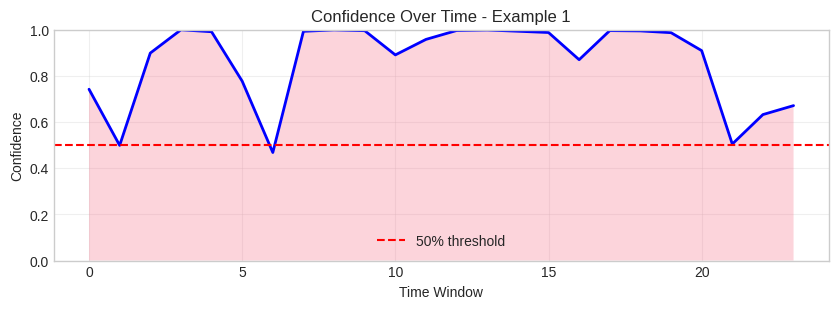

\nSimulating real-time classification for: trendelenburg
--------------------------------------------------
Time  30: Predicted=lurching   Confidence=0.72
Time  35: Predicted=lurching   Confidence=0.73
Time  40: Predicted=lurching   Confidence=0.75
Time  45: Predicted=lurching   Confidence=0.72
Time  50: Predicted=lurching   Confidence=0.68
Time  55: Predicted=lurching   Confidence=0.54
Time  60: Predicted=lurching   Confidence=0.53
Time  65: Predicted=lurching   Confidence=0.52
Time  70: Predicted=normal     Confidence=0.47
Time  75: Predicted=normal     Confidence=0.50
Time  80: Predicted=normal     Confidence=0.54
Time  85: Predicted=normal     Confidence=0.57
Time  90: Predicted=lurching   Confidence=0.57
Time  95: Predicted=lurching   Confidence=0.67
Time 100: Predicted=lurching   Confidence=0.55
Time 105: Predicted=lurching   Confidence=0.47
Time 110: Predicted=lurching   Confidence=0.46
Time 115: Predicted=normal     Confidence=0.43
Time 120: Predicted=normal     Confidence=0.55

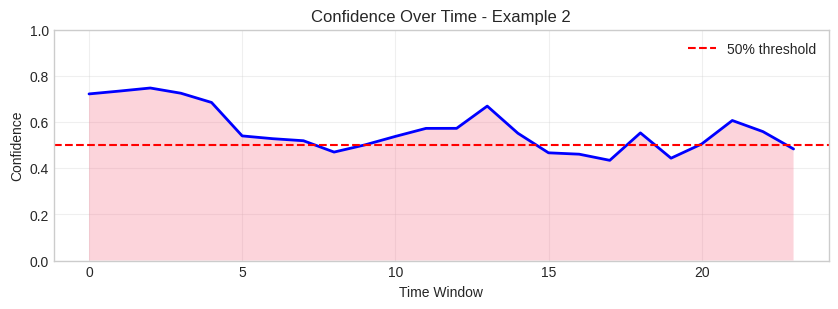

\nSimulating real-time classification for: trendelenburg
--------------------------------------------------
Time  30: Predicted=normal     Confidence=1.00
Time  35: Predicted=normal     Confidence=1.00
Time  40: Predicted=normal     Confidence=1.00
Time  45: Predicted=normal     Confidence=0.99
Time  50: Predicted=normal     Confidence=0.99
Time  55: Predicted=normal     Confidence=1.00
Time  60: Predicted=normal     Confidence=1.00
Time  65: Predicted=normal     Confidence=1.00
Time  70: Predicted=normal     Confidence=1.00
Time  75: Predicted=normal     Confidence=1.00
Time  80: Predicted=normal     Confidence=1.00
Time  85: Predicted=normal     Confidence=0.96
Time  90: Predicted=normal     Confidence=0.97
Time  95: Predicted=normal     Confidence=0.99
Time 100: Predicted=normal     Confidence=0.99
Time 105: Predicted=normal     Confidence=0.99
Time 110: Predicted=normal     Confidence=1.00
Time 115: Predicted=normal     Confidence=0.64
Time 120: Predicted=lurching   Confidence=0.87

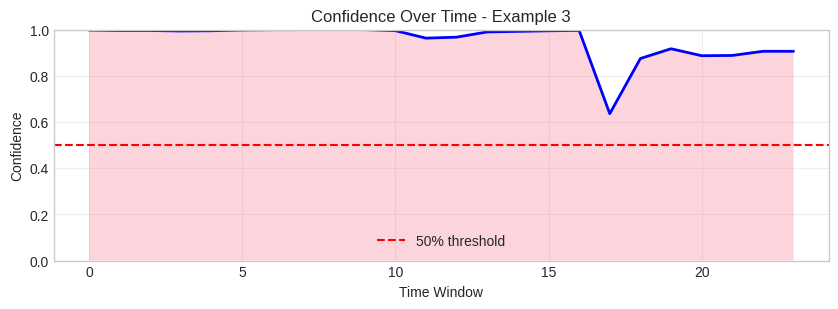

In [20]:
# Simulate on a few examples
print("\n" + "="*70)
print("REAL-TIME STREAMING SIMULATION")
print("="*70)

for i in range(3):
    predictions, confidences = simulator.simulate_stream(i)

    # Plot confidence over time
    plt.figure(figsize=(10, 3))
    plt.plot(confidences, 'b-', linewidth=2)
    plt.fill_between(range(len(confidences)), confidences, alpha=0.3)
    plt.axhline(y=0.5, color='r', linestyle='--', label='50% threshold')
    plt.title(f'Confidence Over Time - Example {i+1}')
    plt.xlabel('Time Window')
    plt.ylabel('Confidence')
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

\n======================================================================
FEATURE IMPORTANCE ANALYSIS


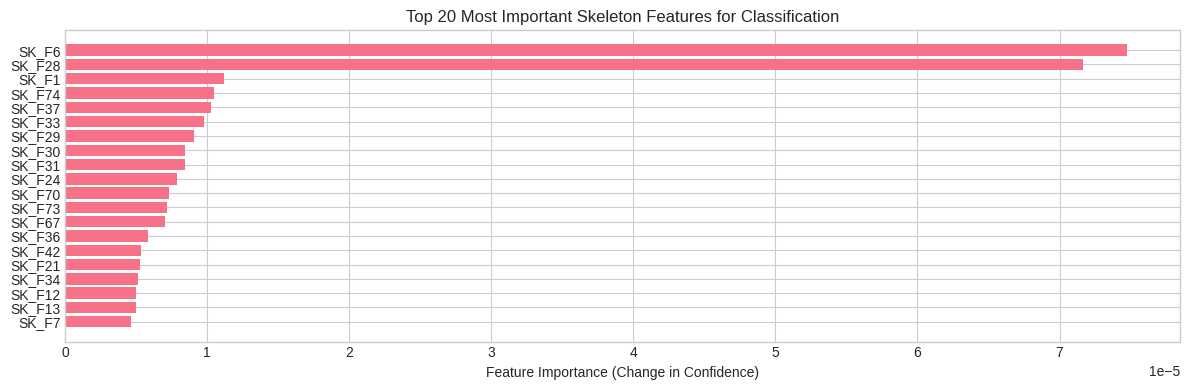

In [21]:
def visualize_feature_importance_multimodal(model, X_sk_sample, X_pr_sample, feature_names=None):
    """Show which SKELETON features the multimodal model focuses on."""

    # Reshape both samples to have a batch dimension of 1
    X_sk_sample_r = X_sk_sample.reshape(1, *X_sk_sample.shape)
    X_pr_sample_r = X_pr_sample.reshape(1, *X_pr_sample.shape)

    # Get baseline prediction using both inputs
    baseline_pred = model.predict([X_sk_sample_r, X_pr_sample_r], verbose=0)[0]
    baseline_class = np.argmax(baseline_pred)

    importance_scores = []

    # Perturb each feature in the SKELETON data
    for feature_idx in range(X_sk_sample.shape[1]):
        # Create a perturbed version of the skeleton sample
        X_perturbed_sk = X_sk_sample.copy()
        X_perturbed_sk[:, feature_idx] = 0  # Zero out one feature column
        X_perturbed_sk_r = X_perturbed_sk.reshape(1, *X_perturbed_sk.shape)

        # Measure prediction change, providing the original pressure data as the second input
        perturbed_pred = model.predict([X_perturbed_sk_r, X_pr_sample_r], verbose=0)[0]
        importance = abs(baseline_pred[baseline_class] - perturbed_pred[baseline_class])
        importance_scores.append(importance)

    # Visualize
    plt.figure(figsize=(12, 4))
    if feature_names is None:
        feature_names = [f'SK_F{i}' for i in range(len(importance_scores))]

    # Sort by importance to show the Top 20
    sorted_idx = np.argsort(importance_scores)[-20:]

    plt.barh(range(len(sorted_idx)), [importance_scores[i] for i in sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance (Change in Confidence)')
    plt.title('Top 20 Most Important Skeleton Features for Classification')
    plt.tight_layout()
    plt.show()

    return importance_scores

# Show feature importance for a sample
print("\\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

sample_idx = 0
# Call the correct function based on the best model type
if best_model_name == 'gru_cnn_fusion':
    # Use the new multimodal function
    importance = visualize_feature_importance_multimodal(best_model, X_test_sk[sample_idx], X_test_pr[sample_idx])
elif best_model_name == 'encoded_gru':
    # Requires the original function
    importance = visualize_feature_importance(best_model, X_test_encoded[sample_idx])
else:
    # For any other single-input model
    importance = visualize_feature_importance(best_model, X_test_sk[sample_idx])

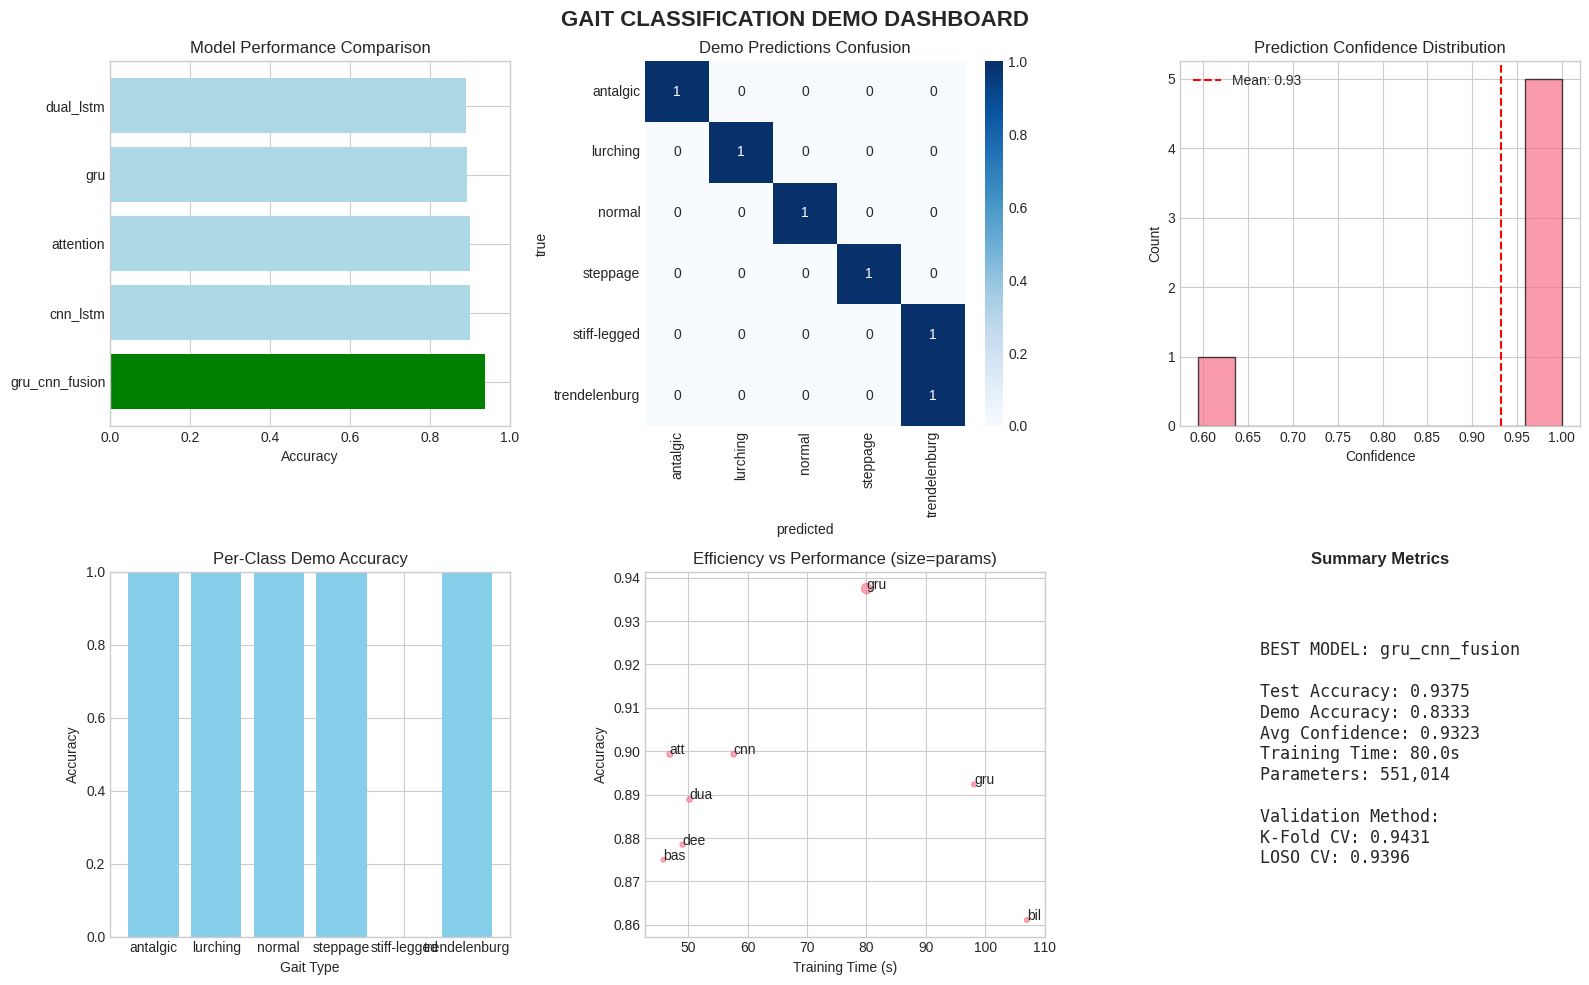

\n✅ Demo complete! Model is ready for deployment.


In [22]:
# Create Summary Dashboard
def create_demo_dashboard(results_df, demo_results):
    """Create a comprehensive dashboard of results"""

    fig = plt.figure(figsize=(16, 10))

    # 1. Model Performance Overview
    ax1 = plt.subplot(2, 3, 1)
    models = results_df['Model'].values[:5]
    accuracies = results_df['Accuracy'].values[:5]
    colors = ['green' if m == best_model_name else 'lightblue' for m in models]
    ax1.barh(models, accuracies, color=colors)
    ax1.set_xlabel('Accuracy')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xlim([0, 1])

    # 2. Confusion Matrix for Demo
    ax2 = plt.subplot(2, 3, 2)
    # Check if demo_results is not empty before creating confusion matrix
    if not demo_results.empty:
        demo_cm = pd.crosstab(demo_results['true'], demo_results['predicted'])
        sns.heatmap(demo_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Demo Predictions Confusion')

    # 3. Confidence Distribution
    ax3 = plt.subplot(2, 3, 3)
    if not demo_results.empty:
        ax3.hist(demo_results['confidence'], bins=10, edgecolor='black', alpha=0.7)
        ax3.axvline(demo_results['confidence'].mean(), color='red',
                    linestyle='--', label=f'Mean: {demo_results["confidence"].mean():.2f}')
        ax3.legend()
    ax3.set_xlabel('Confidence')
    ax3.set_ylabel('Count')
    ax3.set_title('Prediction Confidence Distribution')


    # 4. Per-class accuracy
    ax4 = plt.subplot(2, 3, 4)
    if not demo_results.empty:
        class_acc = demo_results.groupby('true')['correct'].mean()
        ax4.bar(class_acc.index, class_acc.values, color='skyblue')
    ax4.set_xlabel('Gait Type')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Per-Class Demo Accuracy')
    ax4.set_ylim([0, 1])

    # 5. Model efficiency
    ax5 = plt.subplot(2, 3, 5)
    ax5.scatter(results_df['Time (s)'][:8], results_df['Accuracy'][:8],
               s=results_df['Parameters'][:8]/10000, alpha=0.6)
    for idx, row in results_df[:8].iterrows():
        ax5.annotate(row['Model'][:3], (row['Time (s)'], row['Accuracy']))
    ax5.set_xlabel('Training Time (s)')
    ax5.set_ylabel('Accuracy')
    ax5.set_title('Efficiency vs Performance (size=params)')

    # 6. Key metrics summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Safely get and format K-Fold and LOSO results
    kfold_mean = kfold_results.get(best_model_name, {}).get('mean', 'N/A')
    kfold_str = f"{kfold_mean:.4f}" if isinstance(kfold_mean, (int, float)) else kfold_mean

    loso_mean = loso_results.get(best_model_name, {}).get('mean', 'N/A')
    loso_str = f"{loso_mean:.4f}" if isinstance(loso_mean, (int, float)) else loso_mean

    demo_acc_str = f"{demo_results['correct'].mean():.4f}" if not demo_results.empty else "N/A"
    demo_conf_str = f"{demo_results['confidence'].mean():.4f}" if not demo_results.empty else "N/A"

    metrics_text = f"""
    BEST MODEL: {best_model_name}

    Test Accuracy: {results_df.iloc[0]['Accuracy']:.4f}
    Demo Accuracy: {demo_acc_str}
    Avg Confidence: {demo_conf_str}
    Training Time: {results_df.iloc[0]['Time (s)']:.1f}s
    Parameters: {results_df.iloc[0]['Parameters']:,}

    Validation Method:
    K-Fold CV: {kfold_str}
    LOSO CV: {loso_str}
    """
    ax6.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
            fontfamily='monospace')
    ax6.set_title('Summary Metrics', fontweight='bold')

    plt.suptitle('GAIT CLASSIFICATION DEMO DASHBOARD', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Placeholder for demo_results in case the demo failed to run
if 'demo_results' not in locals():
    print("⚠️ Demo results not found. Creating empty placeholder for dashboard.")
    demo_results = pd.DataFrame(columns=['true', 'predicted', 'confidence', 'correct'])

# Create final dashboard
create_demo_dashboard(df_results, demo_results)

print("\\n✅ Demo complete! Model is ready for deployment.")